# Data augmentation

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
#export
from exp.nb_09c import *

## PIL transforms

### View images

In [5]:
#export
make_rgb._order = 0

In [6]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE)

In [7]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [8]:
def get_il(tfms): return ImageList.from_files(path, tfms=tfms)

In [9]:
il = get_il(tfms)

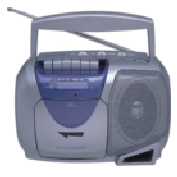

In [10]:
show_image(il[4060])

In [11]:
img = PIL.Image.open(il.items[4060])

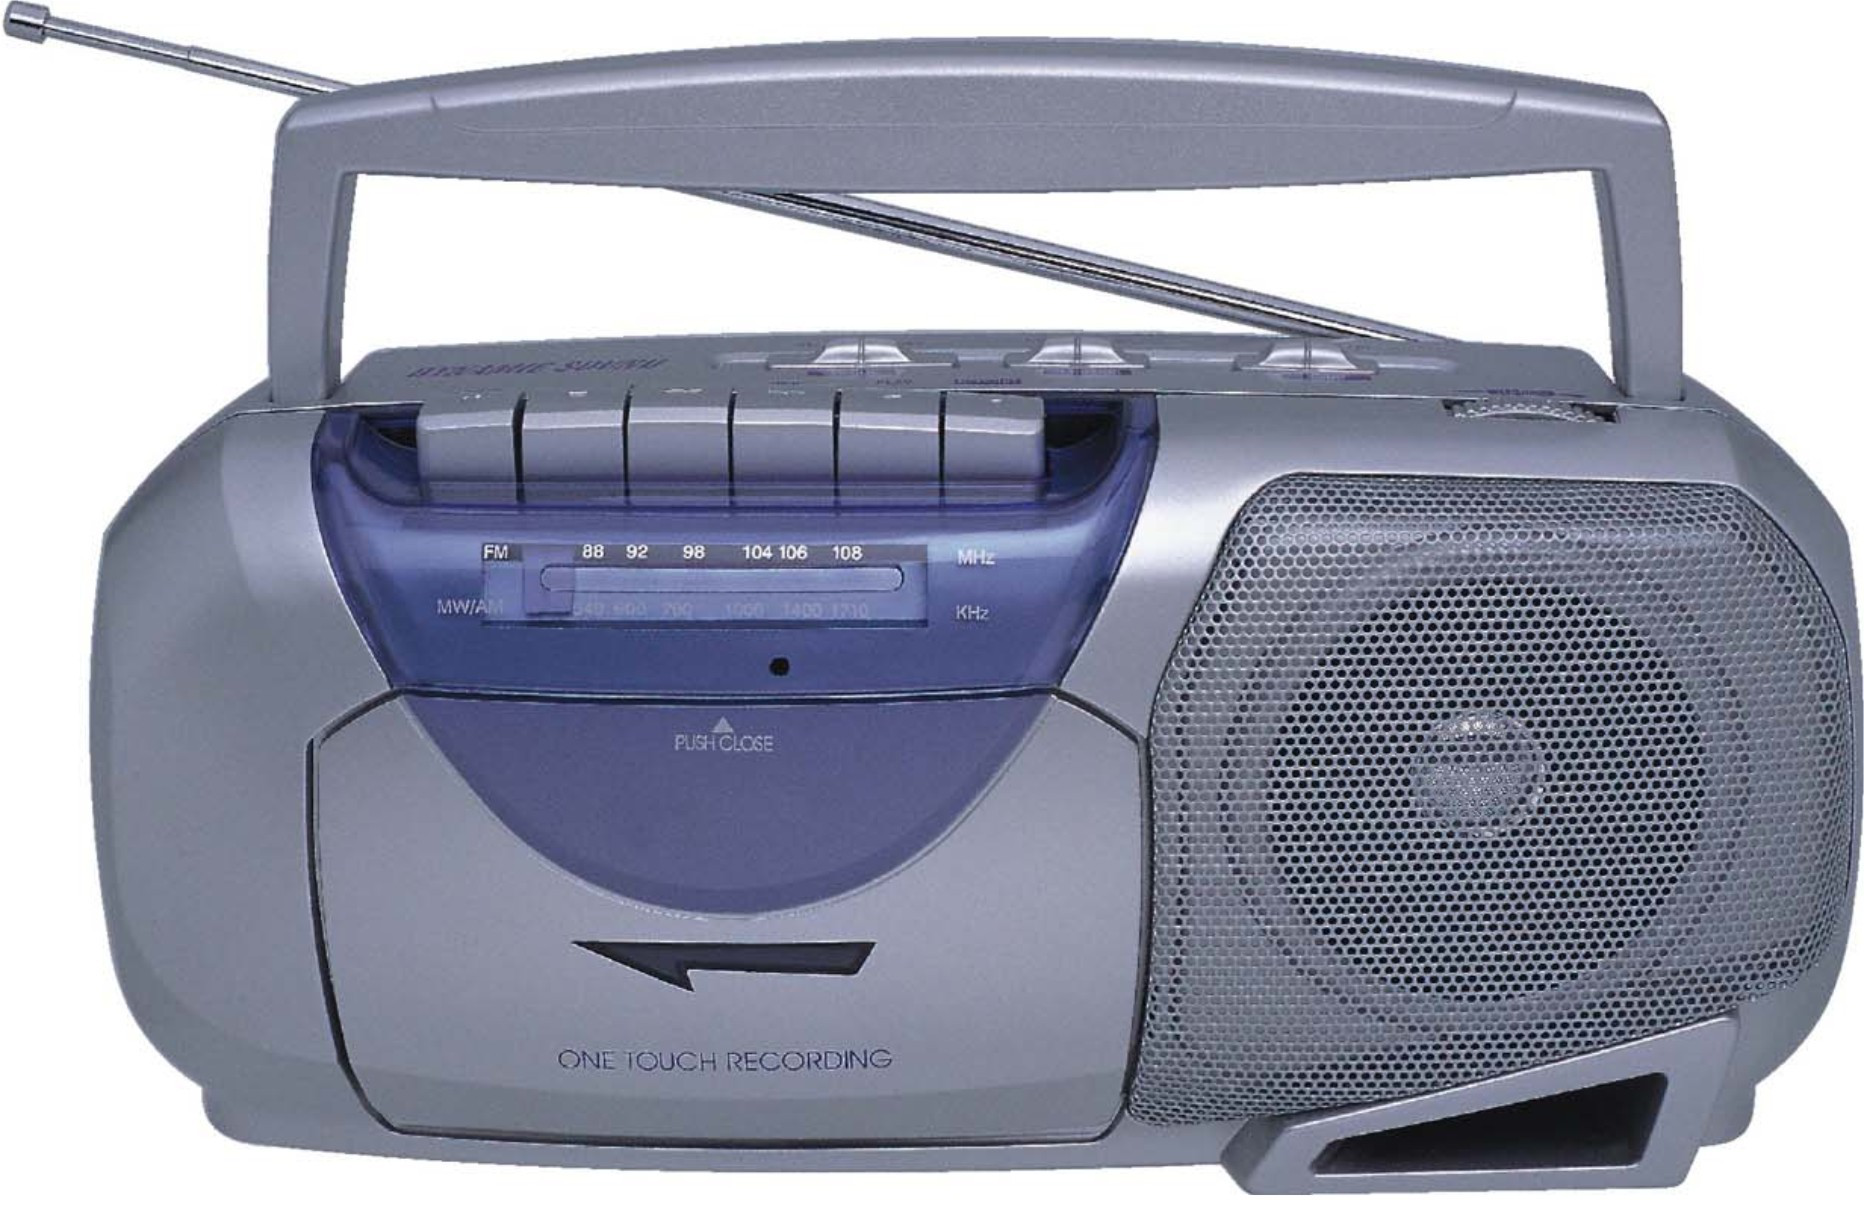

In [12]:
img

In [13]:
img.getpixel((1,1))

(248, 248, 250)

In [14]:
import numpy as np

In [15]:
%timeit -n 10 a = np.array(PIL.Image.open(il.items[0]))

3.37 ms ± 33.3 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Be careful of resampling methods, you can quickly lose some textures!

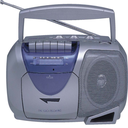

In [16]:
img.resize((128,128), resample=PIL.Image.ANTIALIAS)

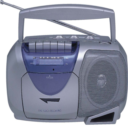

In [17]:
img.resize((128,128), resample=PIL.Image.BILINEAR)

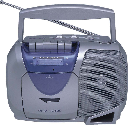

In [18]:
img.resize((128,128), resample=PIL.Image.NEAREST)

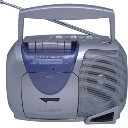

In [19]:
img.resize((256,256), resample=PIL.Image.BICUBIC).resize((128,128), resample=PIL.Image.NEAREST)

In [20]:
%timeit img.resize((224,224), resample=PIL.Image.BICUBIC)

12.3 ms ± 5.55 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit img.resize((224,224), resample=PIL.Image.BILINEAR)

6.94 ms ± 1.66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit img.resize((224,224), resample=PIL.Image.ANTIALIAS)

18.1 ms ± 2.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit img.resize((224,224), resample=PIL.Image.NEAREST)

58.8 µs ± 20 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


### Flip

In [24]:
#export
import random

In [25]:
def pil_random_flip(x):
    return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < 0.5 else x

In [26]:
ill = get_il(tfms)

In [27]:
ill.items = [ill.items[0]] * 64

In [28]:
dl = DataLoader(ill, 8)

In [29]:
x = next(iter(dl))

In [30]:
#export
def show_image(im, ax=None, figsize=(3,3)):
    if ax is None: _, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(im.permute(1,2,0))
    
def show_batch(x, c=4, r=None, figsize=None):
    n = len(x)
    if r is None: r = int(math.ceil(n/c))
    if figsize is None: figsize=(c*3, r*3)
    fig, axes = plt.subplots(r, c, figsize=figsize)
    for xi, ax in zip(x, axes.flat): show_image(xi, ax)

Without data augmentation:

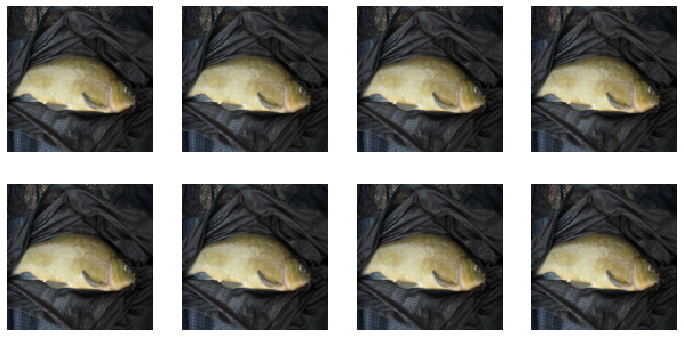

In [31]:
show_batch(x)

Random flip:

In [32]:
ill.tfms.append(pil_random_flip)

In [33]:
x = next(iter(dl))

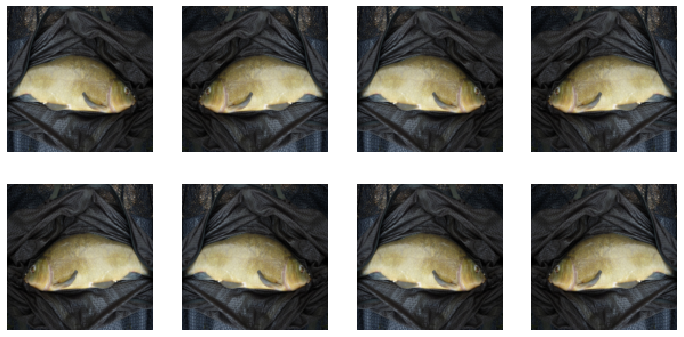

In [34]:
show_batch(x)

In [35]:
??ImageList._get

```python
def _get(self, i): return compose(self.get(i), self.tfms)
```

Let's make the transformation a class so that it is easier to set the flip probablity:

In [36]:
#
class PilTransform(Transform):
    _order = 11
    
class PilRandomFlip(PilTransform):
    def __init__(self, p=0.5): self.p = p
    def __call__(self, x):
        return x.transpose(PIL.Image.FLIP_LEFT_RIGHT) if random.random() < self.p else x

In [37]:
del(ill.tfms[-1])

In [38]:
ill.tfms.append(PilRandomFlip(0.8))

In [39]:
x = next(iter(dl))

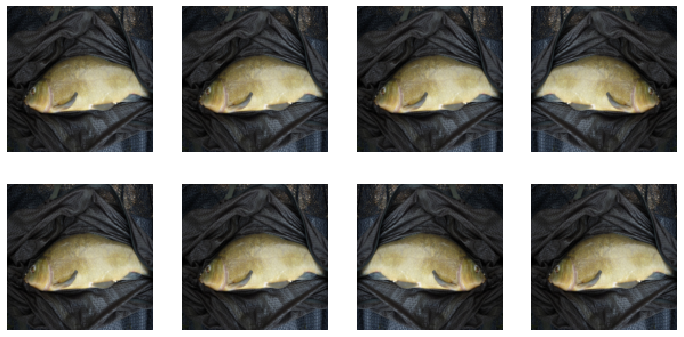

In [40]:
show_batch(x)

PIL can do all dihedral transformations (random horizontal flip, random vertical flip, the four 90 degree rotations):

In [41]:
(PIL.Image.FLIP_LEFT_RIGHT, PIL.Image.ROTATE_270, PIL.Image.TRANSVERSE, PIL.Image.TRANSPOSE)

(0, 4, 6, 5)

`img.transpose(0)` already is assigned to a transform, doing nothing, thus, requires a separate case. This leaves us 7 transforms.

In [42]:
img = PIL.Image.open(il.items[0])
img = img.resize((128, 128), resample=PIL.Image.NEAREST)

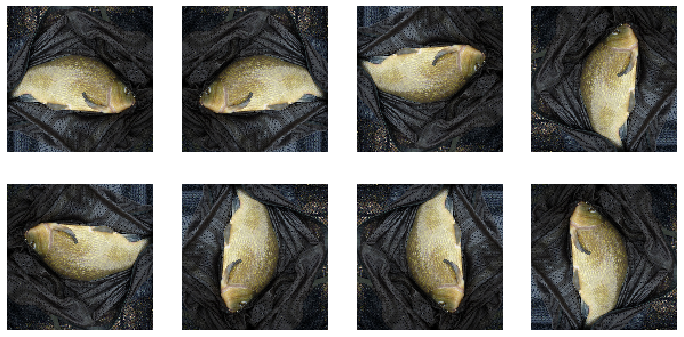

In [43]:
_, axes = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axes.flatten()):
    if i == 0: ax.imshow(img)
    else: ax.imshow(img.transpose(i - 1))
    ax.axis('off')

In [44]:
#export
class PilRandomDihedral(PilTransform):
    def __init__(self, p=0.75): self.p = p * 7/8  # To take the 1/8 idendity dihedral into account
    def __call__(self, x):
        if random.random() > self.p: return x
        return x.transpose(random.randint(0, 6))

In [45]:
del(ill.tfms[-1])

In [46]:
tfms.append(PilRandomDihedral())

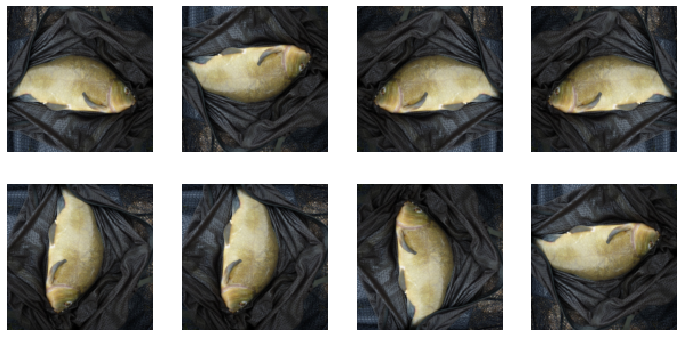

In [47]:
show_batch(next(iter(dl)))

### Random crop

In [48]:
img = PIL.Image.open(il.items[0])

In [49]:
img.size

(500, 375)

In order to crop an image with PIL we have to specify the top-left and bottom-right coordinates in the format `(left, top, right, bottom)`. We first crop the section we want (`crop_size` from here on) and then resize:

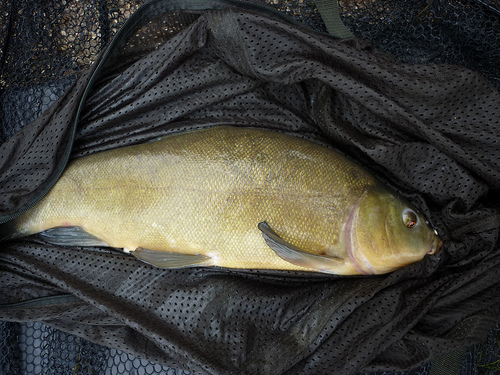

In [50]:
img

In [51]:
cnr2 = (60,60,320,320)
resample = PIL.Image.BILINEAR

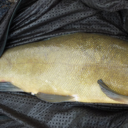

In [52]:
img.crop(cnr2).resize((128, 128), resample=resample)

In [53]:
%timeit img.crop(cnr2).resize((128, 128), resample=resample)

420 µs ± 112 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Our time budget: aim for 5 mins per batch for imagenet on 8 GPUs. 1.25m images in imagenet. So on one GPU per minute that's 1250000/8/5 == 31250, or 520 per second. Assuming 4 cores per GPU, then we want ~125 images per second - so try to stay <10ms per image. Here we have time to do more things. For instance, we can do the crop and resize in the same call to transform, which will give a smoother result.

In [59]:
%timeit -n 10 img.transform((128,128), PIL.Image.EXTENT, cnr2, resample=resample)

648 µs ± 7.55 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Our time budget: aim for 5 mins per batch for imagenet on 8 GPUs. 1.25m images in imagenet. So on one GPU per minute that's 1.520.000/8/5 == 31250, or 520 per second. Assuming 4 cores per GPU, then we want ~125 images per second - so try to stay <10ms per image. Here we have time to do more things. For instance, we can do the crop and resize in the same call to transform, which will give a smoother result.

We now define a general crop transformation and two subclasses, one for training with random crops and one for validation with center crops.

The subclasses only  the method 

In [54]:
#export
from random import randint

def process_sz(sz):
    sz = listify(sz)
    return tuple(sz if len(sz) == 2 else [sz[0], sz[0]])

def default_crop_size(w, h):
    return [w,w] if w < h else [h,h]

In [57]:
process_sz(200)

(200, 200)

In [58]:
process_sz([200,600])

(200, 600)

In [120]:
#export
class GeneralCrop(PilTransform):
    def __init__(self, size, crop_size=None, resample=PIL.Image.BILINEAR):
        self.resample, self.size = resample, process_sz(size)
        self.crop_size = None if crop_size is None else process_sz(crop_size)
        
    def default_crop_size(self, w, h):
        return default_crop_size(w, h)
    
    def __call__(self, x):
        csize = self.default_crop_size(*x.size) if self.crop_size is None else self.crop_size
        # not necessarily preserving the aspect ratio

        return x.transform(self.size, PIL.Image.EXTENT, self.get_corners(*x.size, *csize), resample=self.resample)
    
    def get_corners(self, w, h):
        return (0, 0, w, h)

In [121]:
#export
class CenterCrop(GeneralCrop):
    def __init__(self, size, scale=1.14, resample=PIL.Image.BILINEAR):
        super().__init__(size, resample=resample)
        self.scale = scale
        
    def default_crop_size(self, w, h):
        return [w/self.scale, h/self.scale]
    
    def get_corners(self, w, h, wc, hc):
        return ((w - wc)//2, (h-hc)//2, (w-wc)//2+wc, (h-hc)//2+hc)

In [124]:
ill.tfms = [make_rgb, CenterCrop(128, scale=1.14), to_byte_tensor, to_float_tensor]

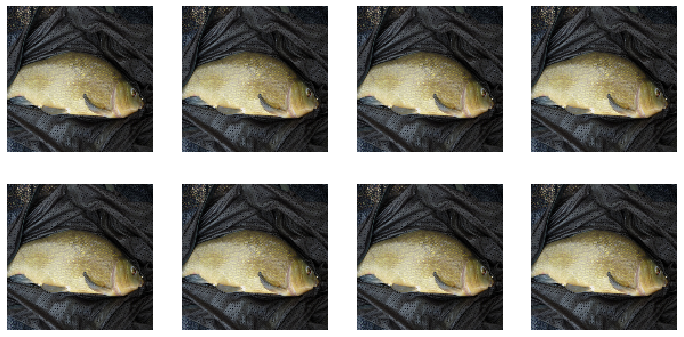

In [125]:
show_batch(next(iter(dl)))